In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
model = "mlp"

In [9]:
loss = pickle.load(open(f"loss_info/{model}.pkl", "rb"))

Text(0, 0.5, 'Loss')

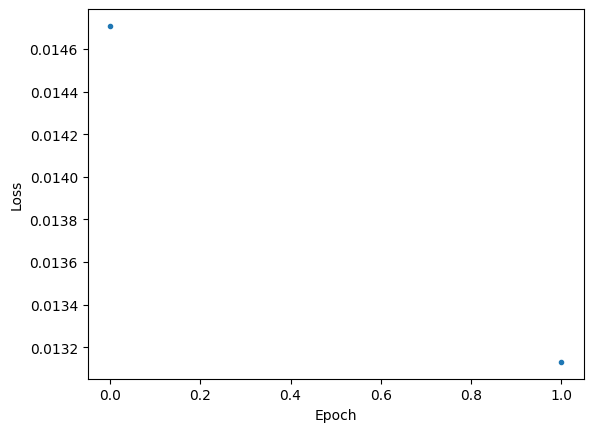

In [15]:
plt.plot(loss['loss'],'.')
plt.xlabel('Epoch')
plt.ylabel('Loss')